These are the equations that model the Brusselator. 

$$\frac{dx}{dt} = A - (B + 1)x + x^2 y$$
$$\frac{dy}{dt} = Bx - x^2 y$$

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

# Equation Parameters
A = 1.0
B = 1.5

def vector_function(t, state, a, b):
    '''
    Returns a 2D vector containing the derivatives `[dx/dt, dy/dt]` of the current state.
    '''
    x, y = state
    dx_dt = a - (b + 1)*x + x**2 * y
    dy_dt = b*x - x**2 * y
    # Shape is defined by this return value.
    return [dx_dt, dy_dt]

T_START = 0
T_END = 50
TIME_SPAN = (T_START, T_END)
t_points = np.linspace(T_START, T_END, num=100)

def solve(a = A, b = B):
    '''
    Uses `solve_ivp()` function to solve equation. Returns the results as arrays of
    an object (e.g. time solutions are `solve().t`, x solutions are `solve().y[0]`,
    and y-solutions are `solve().y[1]`).
    '''
    x_0 = 1.2
    y_0 = 2.8
    initial_conditions = (x_0, y_0)
    return solve_ivp(
        vector_function,
        args=(a, b),
        t_span=TIME_SPAN,
        t_eval=t_points,
        y0=initial_conditions,
        method='RK45',
    )
    
solutions = solve()
t_solutions = solutions.t
x_solutions = solutions.y[0]
y_solutions = solutions.y[1]

Now, it's time to graph the solutions for $x$ and $y$ with respect to $t$.

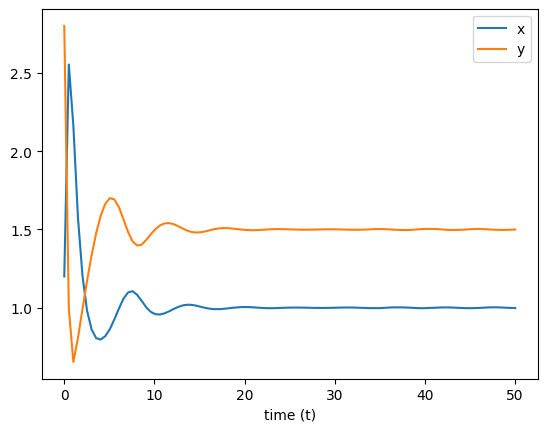

In [41]:
import matplotlib.pyplot as plt

def plot_xy_by_t(axes, t_pts, x_sol = None, y_sol = None, show_legend = True):
    axes.set_xlabel('time (t)')
    if x_sol is not None:
        axes.plot(t_pts, x_sol, label='x')
    if y_sol is not None:
        axes.plot(t_pts, y_sol, label='y')
    if show_legend:
        axes.legend()
    # ax.axhline(y=A, linestyle='--', color='r')
    # ax.axhline(y=B, linestyle='--', color='g')

fig, ax = plt.subplots()

plot_xy_by_t(
    ax,
    t_points,
    x_solutions,
    y_solutions
)

plt.show()

Now, I am plotting the positions of the $x$ and $y$ values over time $(x, y)$.

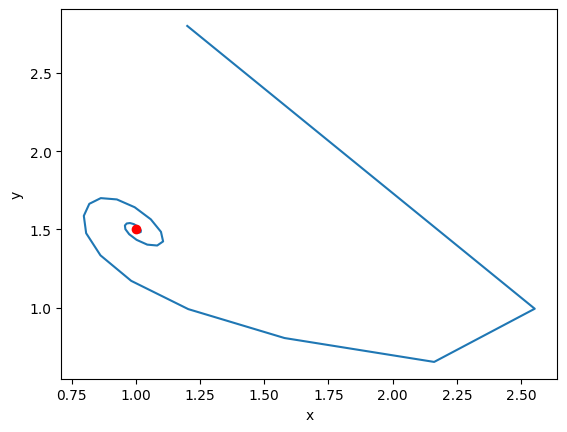

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(x_solutions, y_solutions)
ax.plot(A, B, marker='o', color='red')
plt.show()

Paramter sweep of $B$ over $[1.2, 3.5]$.

Behavior for B=1.2: equilibrium
Behavior for B=1.409090909090909: equilibrium
Behavior for B=1.6181818181818182: equilibrium
Behavior for B=1.8272727272727272: equilibrium
Behavior for B=2.036363636363636: oscilating
	Wavelength: 13
	Amplitude: 1.4257033058718354
Behavior for B=2.245454545454545: oscilating
	Wavelength: 12
	Amplitude: 1.7472095534063268
Behavior for B=2.454545454545454: oscilating
	Wavelength: 12
	Amplitude: 2.1197129637400067
Behavior for B=2.6636363636363636: oscilating
	Wavelength: 13
	Amplitude: 2.2190159424896208
Behavior for B=2.8727272727272726: oscilating
	Wavelength: 13
	Amplitude: 2.4988126858679265
Behavior for B=3.0818181818181816: oscilating
	Wavelength: 13
	Amplitude: 2.779466741716877
Behavior for B=3.290909090909091: oscilating
	Wavelength: 15
	Amplitude: 3.18078132863786
Behavior for B=3.5: oscilating
	Wavelength: 16
	Amplitude: 3.6510587419296012


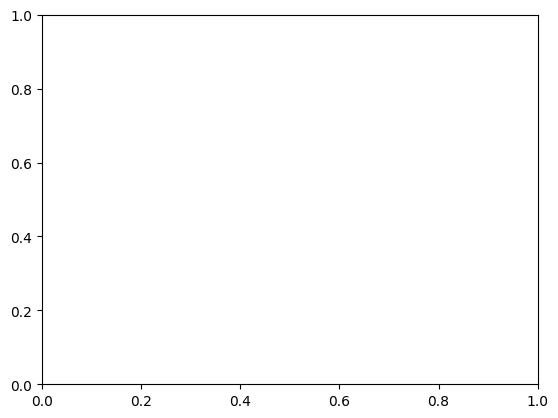

In [50]:
from typing import Literal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def classify_behavior(t_sol, x_sol) -> Literal['equilibrium', 'oscilating']:
    # This is the tolerance for how much the function can deviate from the mean in interval. 
    # If the function is within tolerance, then it is classifed as being at equilibrium.
    TOLERANCE = 0.05
    # This test is only concerned about the end behavior, so it only considers the last (100 - END_THRESHOLD)%.
    END_THRESHOLD = int(len(t_sol) * 0.8)
    # Extract the last (100 - END_THRESHOLD)% of x-values
    x_solutions = x_sol[END_THRESHOLD:]
    standard_deviation =  np.std(x_solutions)
    if standard_deviation <= TOLERANCE:
        return 'equilibrium'
    else:
        return 'oscilating'

def estimate_value(x_idx, x_values, y_values) -> int:
    '''
    Estimates the value of y at x using linear interpolation. Works well
    when x-values are close together.
    '''

    # Finds the minimum of the difference between each x-value and x.
    # 
    # I can find the values by getting the first index since each value in
    # x_values in unique.
    x_1 = np.argmin(np.abs(x_values - x_values[x_idx]))
    # The next x-value after the closest one.
    x_2 = min(x_1 + 1, len(x_values) - 1)
    y_1 = y_values[x_1]
    y_2 = y_values[x_2]
    return (y_1 + y_2) / 2
    

def calc_amplitude_and_period(x_values, y_values) -> tuple[float, float]:
    peaks, _ = find_peaks(y_values)
    # TODO: Calculate average wavelength
    period = peaks[1] - peaks[0]
    amplitudes = [estimate_value(peak, x_values, y_values) for peak in peaks]
    avg_amplitude = np.average(amplitudes)
    return (period, avg_amplitude)
    

B_RANGE = (1.2, 3.5)
b_start, b_end = B_RANGE
b_points = np.linspace(b_start, b_end, num=12)

fig, ax = plt.subplots()

for point in b_points:
    solutions = solve(b=point)
    t_solutions = solutions.t
    x_solutions = solutions.y[0]
    behavior = classify_behavior(t_solutions, x_solutions)
    print(f'Behavior for B={point}: {behavior}')
    if behavior == 'oscilating':
        (period, amplitude) = calc_amplitude_and_period(
            x_values=t_solutions,
            y_values=x_solutions
        )
        print(f"\tWavelength: {period}")
        print(f"\tAmplitude: {amplitude}")
